In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import sys
sys.path.append("../")

In [2]:

import pickle
import glob
from tqdm.notebook import trange, tqdm
from features import prepare_entry
import numpy as np
import pandas as pd 
from utills import chunker, cartesian_product 
from features import prepare_entry, get_transformer, merge_entries
from data_collection_methods import reddit_user_comments, reddit_user_submissions
import seaborn as sn
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from psaw import PushshiftAPI
import datetime as dt
import gc

In [3]:
from datetime import datetime
import re
import json
import time
import requests

In [45]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import rcParams
%matplotlib inline

In [4]:
import networkx as nx
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [6]:
DATA_DIR = '../data/sockpuppets/reddit_suspicous/'
TEMP_DATA_DIR = '../temp_data/sockpuppets/reddit_suspicious/'
MULTIDOC_MODEL_PATH = '../temp_data/reddit/multidoc_20/model_20.p'
SINGLEDOC_MODEL_PATH = '../temp_data/reddit/unchunked/model.p'

Load Model
==

In [7]:
chunk_sz = 20
with open(MULTIDOC_MODEL_PATH, 'rb') as f:
    (clf, transformer, scaler, secondary_scaler, _) = pickle.load(f)

with open(SINGLEDOC_MODEL_PATH, 'rb') as f:
    (clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc, _) = pickle.load(f)

Download Reddit Suspicious Data
===

In [12]:
with open(DATA_DIR + 'usernames.txt', 'r') as f:
    usernames = [l.strip() for l in f.readlines()]

In [13]:
after = str(int(datetime(2008, 1, 1).timestamp()))
before = str(int(datetime.now().timestamp()))

In [14]:
completed_users_reddit = [re.search('user_content/(.*).jsonl', f).group(1) for f in glob.glob(DATA_DIR + 'user_content/*.jsonl')]
failed_reddit = ['[deleted]']

In [ ]:
for u in tqdm(usernames):
    try:
        print(u)
        if u in completed_users_reddit or u in failed_reddit:
            continue
        all_comments = reddit_user_comments(u, after, before)
        all_subs = reddit_user_submissions(u, after, before)
        print(u, len(all_comments), len(all_subs))
        completed_users_reddit.append(u)
        if len(all_comments)  + len(all_subs) < 100:
            continue
        with open(DATA_DIR + '/user_content/' + u + '.jsonl', 'w') as f:
            for c in all_comments:
                json.dump(c, f)
                f.write('\n')
            for c in all_subs:
                json.dump(c, f)
                f.write('\n')
    except Exception as e:
        print('Failed: ', e)
        failed_reddit.append(u)

Preprocess
===

In [8]:
usernames = [re.search('user_content/(.*).jsonl', f).group(1) for f in glob.glob(DATA_DIR + '/user_content/*.jsonl')]

In [9]:
preprocessed = {}
for fp in tqdm(glob.glob(DATA_DIR + 'user_content/*.jsonl')):
    with open(fp, 'r') as f:
        comments = [json.loads(l) for l in f]
    user = re.search('user_content/(.*).jsonl', fp).group(1)
    preprocessed[user] = [prepare_entry('\n'.join(chunk), mode='accurate', tokenizer='casual') for chunk in  chunker(comments, chunk_sz)]

In [10]:
with open(TEMP_DATA_DIR + 'preprocessed.p', 'wb') as f:
    pickle.dump(preprocessed, f)

In [ ]:
with open(TEMP_DATA_DIR + 'preprocessed.p', 'rb') as f:
    preprocessed = pickle.load(f)

Vectorize
===

In [11]:
usernames = list(preprocessed.keys())
user_bounds = {}
X = []
X_nc = []
for u in tqdm(usernames):
    x = scaler.transform(transformer.transform(preprocessed[u]).todense())
    user_bounds[u] = (len(X), len(X) + len(x))
    X.extend(x)
    
    x_nc = scaler_nc.transform(transformer_nc.transform([merge_entries(preprocessed[u])]).todense())[0]
    X_nc.append(x_nc)
X = np.array(X)
X_nc = np.array(X_nc)

Make Predictions
==

In [12]:
jobs = []
for i in range(len(usernames)):
    for j in range(i):
        jobs.append((i, j))
jobs = np.array(jobs)

In [13]:
probs_nc = []

    
inter_probs_mean = []
inter_probs_std = []

intraA_probs_mean = []
intraA_probs_std = []

intraB_probs_mean = []
intraB_probs_std = []
pred_lengths = []

for i, j in tqdm(jobs):
    start_a, end_a = user_bounds[usernames[i]]
    start_b, end_b = user_bounds[usernames[j]]
    
    l = []
    idxs = cartesian_product(range(start_a, end_a), range(start_b, end_b))        
    x_diff = secondary_scaler.transform(np.abs(X[idxs[:, 0]] - X[idxs[:, 1]]))
    x_diff[np.isnan(x_diff)]=0
    p = clf.predict_proba(x_diff)[:, 1]
    inter_probs_mean.append(p.mean())
    inter_probs_std.append(p.std())
    l.append(len(p))
    
    idxs = cartesian_product(range(start_a, end_a), range(start_a, end_a))
    idxs = np.array([(i, j) for i, j in idxs if i != j])
    x_diff = secondary_scaler.transform(np.abs(X[idxs[:, 0]] - X[idxs[:, 1]]))
    x_diff[np.isnan(x_diff)]=0
    p = clf.predict_proba(x_diff)[:, 1]
    intraA_probs_mean.append(p.mean())
    intraA_probs_std.append(p.std())
    l.append(len(p))
    
    idxs = cartesian_product(range(start_b, end_b), range(start_b, end_b))
    idxs = np.array([(i, j) for i, j in idxs if i != j])
    x_diff = secondary_scaler.transform(np.abs(X[idxs[:, 0]] - X[idxs[:, 1]]))
    x_diff[np.isnan(x_diff)]=0
    p = clf.predict_proba(x_diff)[:, 1]
    intraB_probs_mean.append(p.mean())
    intraB_probs_std.append(p.std())
    l.append(len(p))
    
    pred_lengths.append(l)
    
    p = clf_nc.predict_proba(secondary_scaler_nc.transform(np.abs(X_nc[[i], :] - X_nc[[j], :])))[0, 1]
    probs_nc.append(p)

In [16]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
pred_lengths = np.array(pred_lengths)


probs_nc = np.array(probs_nc)

n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)


In [38]:
inter_intra_sim = (1 - np.abs(inter_probs_mean - intra_probs_mean))
aggr_score = (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean)))

In [57]:

fig = go.Figure()
fig.add_trace(go.Histogram(x=aggr_score, name='Aggr Score', nbinsx=20))

In [41]:

fig = go.Figure()
fig.add_trace(go.Histogram(x=probs_nc, name='Intra Author Means'))

In [40]:

fig = go.Figure()
fig.add_trace(go.Histogram(x=inter_probs_mean, name='Intra Author Means'))

In [66]:

fig = go.Figure()
fig.add_trace(go.Histogram(x=intra_probs_mean, name='Intra Author Means'))

In [72]:
usernames = np.array(usernames)

In [82]:
np.argwhere(aggr_score > 0.99)[:, 0]

array([ 81, 172, 330])

In [ ]:
for j_idx in np.argwhere(aggr_score > 0.99)[:, 0]:
    i, j = jobs[j_idx]
    print(usernames[i], usernames[j])
    print('Intra Author:', intraA_probs_mean[j_idx], intraB_probs_mean[j_idx])

Export for graph visualization
===

In [67]:
G = nx.Graph()
G.add_weighted_edges_from([
    (usernames[jobs[i][0]], usernames[jobs[i][1]], aggr_score[i]) 
    for i in np.argwhere(selected_mask)[:, 0]
])

nx.write_gexf(G, 'suspicious_accounts.gexf')

Plot things
===

In [86]:
FIGURES_PATH = '../figures/'
TEXT_WIDTH = 7.0 # Text with on a column
HALF_COL_WIDTH = (TEXT_WIDTH - 0.5)/2
HEIGHT = 2


style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=9 

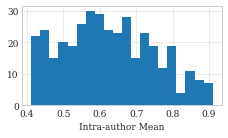

In [87]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))

plt.hist(intra_probs_mean, bins=20)

plt.xlabel('Intra-author Mean')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()
fig.savefig(FIGURES_PATH + 'plt_reddid_sus_intra_author_mean.pdf', bbox_inches='tight')

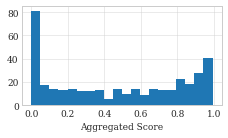

In [88]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))

plt.hist(aggr_score, bins=20)

plt.xlabel('Aggregated Score')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()
fig.savefig(FIGURES_PATH + 'plt_reddid_sus_aggre_score.pdf', bbox_inches='tight')